In [1]:
# Library

import pandas as pd
import numpy as np


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import OrdinalEncoder, BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

# Model Selection
from sklearn.metrics import recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

# Set max columns
pd.set_option('display.max_columns', None)



## **Data Cleaning**
Mostly just outlier removal and handling some categorical variables.

In [2]:
df = pd.read_csv('data_travel_insurance.csv')

In [3]:
df

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No


In [4]:
pd.DataFrame({
    'total': df.shape[0],
    'null_count': df.isna().sum(),
    'null_pct':   [f"{val:.2f}%" for val in (df.isna().sum() / df.shape[0] * 100)],
    'unique_count': df.nunique(),
    'dtype': df.dtypes
}).rename_axis('column')

,total,null_count,null_pct,unique_count,dtype
column,,,,,
Agency,44328,0,0.00%,16,object
Agency Type,44328,0,0.00%,2,object
Distribution Channel,44328,0,0.00%,2,object
Product Name,44328,0,0.00%,26,object
Gender,44328,31647,71.39%,2,object
Duration,44328,0,0.00%,437,int64
Destination,44328,0,0.00%,138,object
Net Sales,44328,0,0.00%,1006,float64
Commision (in value),44328,0,0.00%,915,float64


In [5]:
df.duplicated().sum()

4667

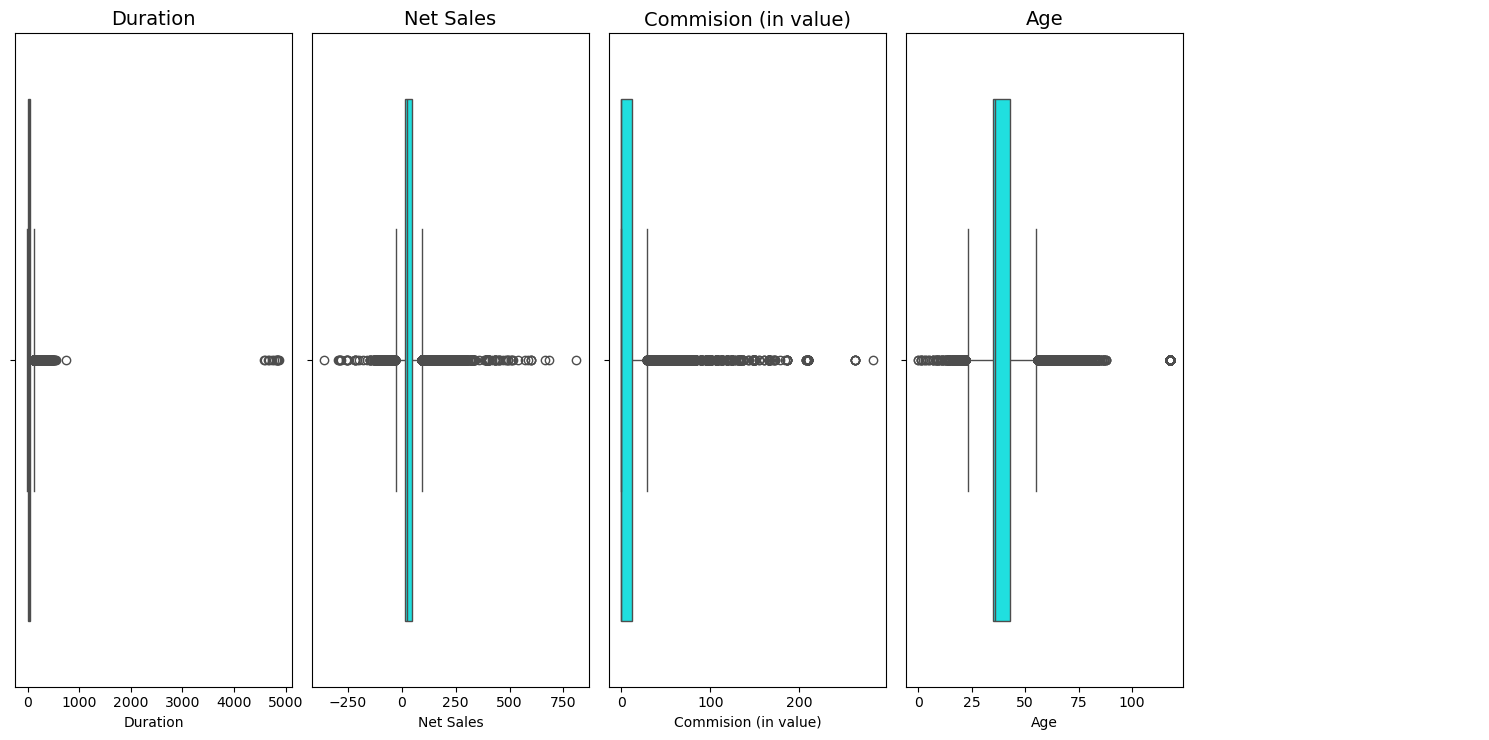

In [6]:
numerical_cols = df.select_dtypes(include=['number']).columns
num_cols = 5
num_rows = int(np.ceil(len(numerical_cols) / num_cols))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 7.5))


axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x=col, ax=axes[i], color='cyan')
    axes[i].set_title(col, fontsize=14)

        
for ax in axes[len(numerical_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
df[numerical_cols].describe()

,Duration,Net Sales,Commision (in value),Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600
std,109.153961,48.661970,19.625637,13.954926
min,-1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


In [8]:
df[df['Age'] == 0]

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
37815,TST,Travel Agency,Offline,Travel Cruise Protect,F,94,THAILAND,-30.0,10.5,0,No
44319,TST,Travel Agency,Offline,Travel Cruise Protect,F,94,THAILAND,30.0,10.5,0,No


In [9]:
df[df['Age'] >100]

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
99,ART,Airlines,Online,Value Plan,M,7,MALAYSIA,29.0,10.15,118,No
105,JZI,Airlines,Offline,Basic Plan,NaN,16,INDONESIA,37.0,12.95,118,No
363,JWT,Airlines,Online,Value Plan,F,12,INDIA,39.0,15.60,118,No
373,JWT,Airlines,Online,Value Plan,M,6,INDIA,39.0,15.60,118,No
727,JWT,Airlines,Online,Value Plan,F,76,INDIA,100.0,40.00,118,No
...,...,...,...,...,...,...,...,...,...,...,...
44089,JWT,Airlines,Online,Value Plan,M,42,INDIA,31.0,12.40,118,No
44140,JWT,Airlines,Online,Value Plan,M,84,INDIA,93.0,37.20,118,No
44150,JWT,Airlines,Online,Value Plan,M,5,INDIA,39.0,15.60,118,No
44160,JWT,Airlines,Online,Value Plan,M,0,INDIA,31.0,12.40,118,No


In [10]:
df = df.query("Age > 0 and Age < 100")

In [11]:
df = df.query("Duration <= 4000")

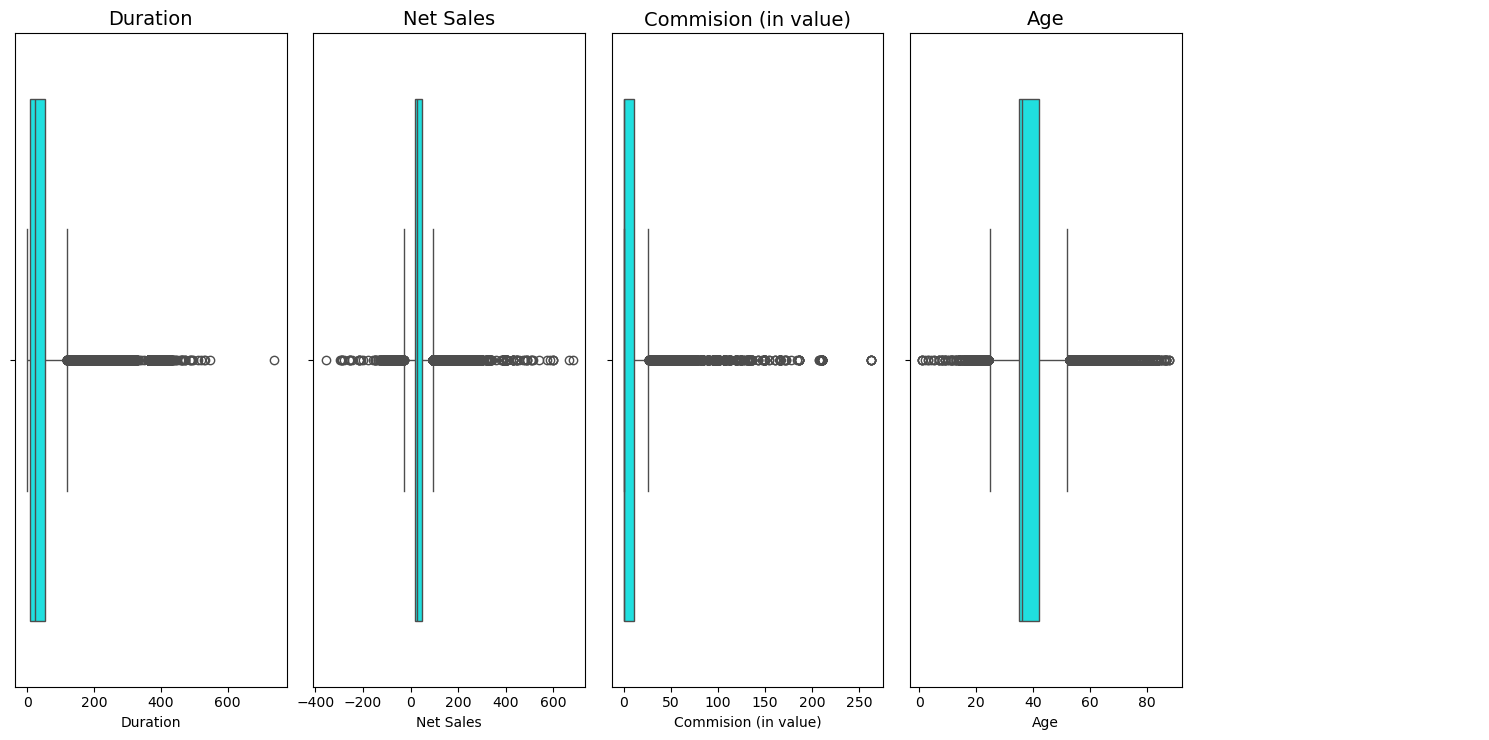

In [12]:
numerical_cols = df.select_dtypes(include=['number']).columns
num_cols = 5
num_rows = int(np.ceil(len(numerical_cols) / num_cols))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 7.5))


axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x=col, ax=axes[i], color='cyan')
    axes[i].set_title(col, fontsize=14)

        
for ax in axes[len(numerical_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [13]:
df = df.query("Duration <= 600")

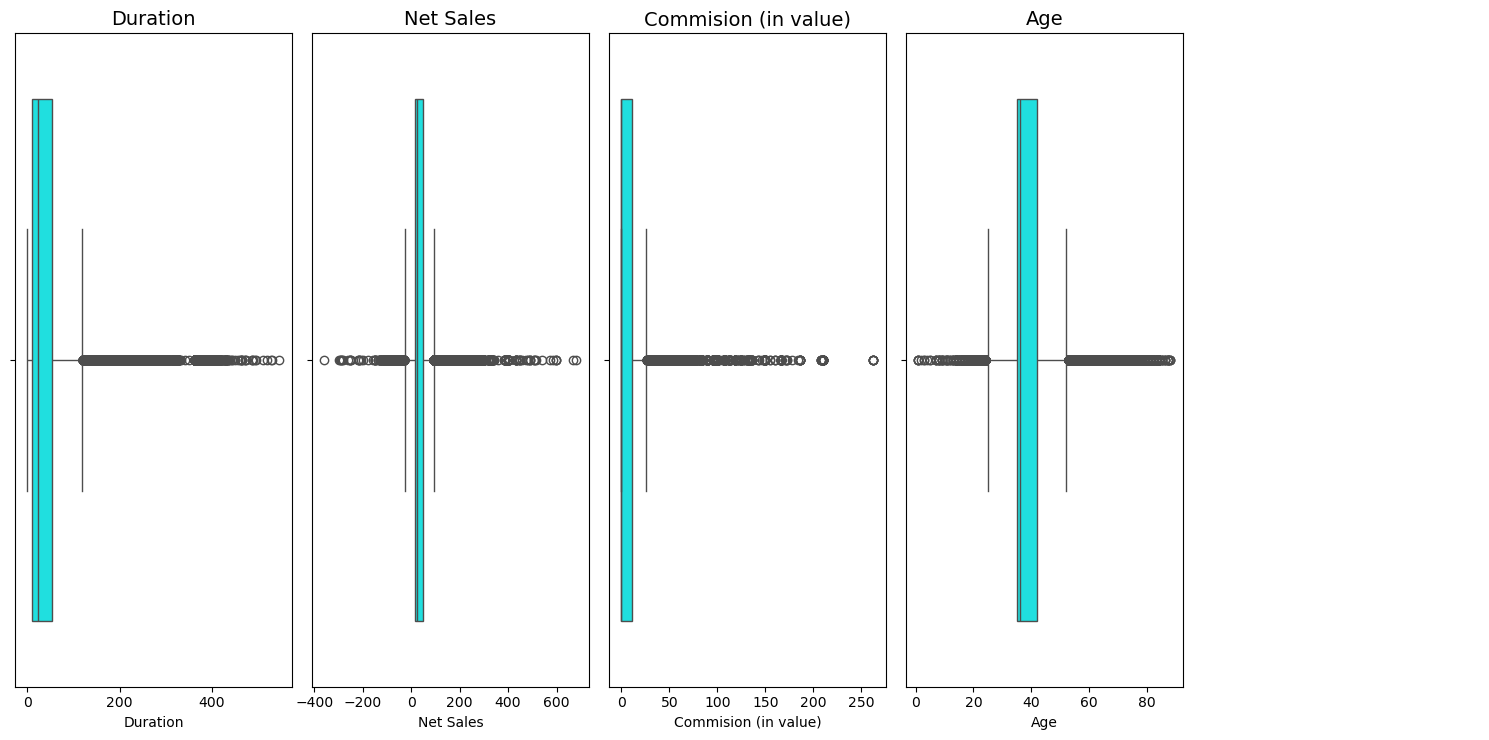

In [14]:
numerical_cols = df.select_dtypes(include=['number']).columns
num_cols = 5
num_rows = int(np.ceil(len(numerical_cols) / num_cols))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 7.5))


axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x=col, ax=axes[i], color='cyan')
    axes[i].set_title(col, fontsize=14)

        
for ax in axes[len(numerical_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [15]:
df = df.query("`Commision (in value)` <= 190")

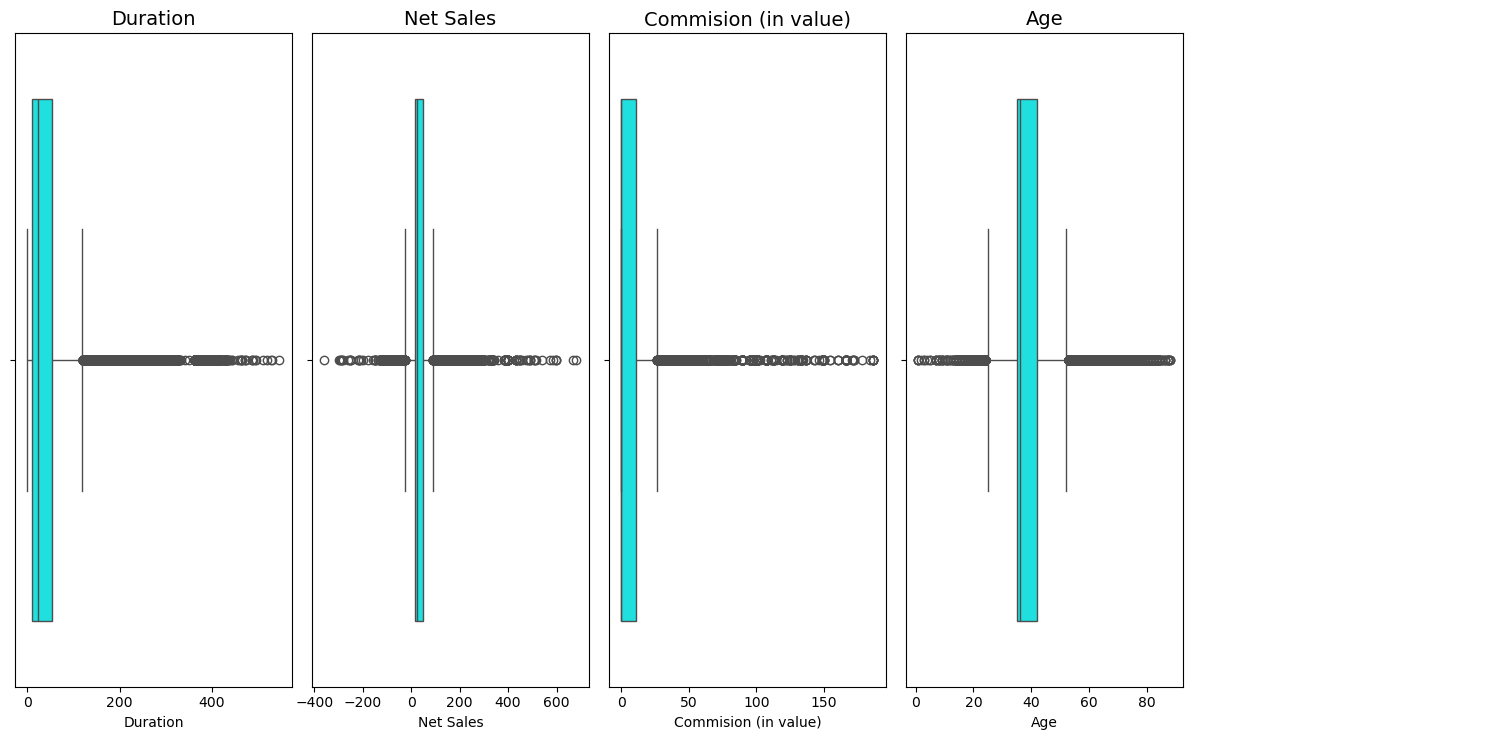

In [16]:
numerical_cols = df.select_dtypes(include=['number']).columns
num_cols = 5
num_rows = int(np.ceil(len(numerical_cols) / num_cols))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 7.5))


axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x=col, ax=axes[i], color='cyan')
    axes[i].set_title(col, fontsize=14)

        
for ax in axes[len(numerical_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [17]:
pd.DataFrame({
    'total': df.shape[0],
    'null_count': df.isna().sum(),
    'null_pct':   [f"{val:.2f}%" for val in (df.isna().sum() / df.shape[0] * 100)],
    'unique_count': df.nunique(),
    'dtype': df.dtypes
}).rename_axis('column')

,total,null_count,null_pct,unique_count,dtype
column,,,,,
Agency,43599,0,0.00%,15,object
Agency Type,43599,0,0.00%,2,object
Distribution Channel,43599,0,0.00%,2,object
Product Name,43599,0,0.00%,26,object
Gender,43599,31533,72.33%,2,object
Duration,43599,0,0.00%,421,int64
Destination,43599,0,0.00%,136,object
Net Sales,43599,0,0.00%,981,float64
Commision (in value),43599,0,0.00%,879,float64


In [18]:
df.drop(columns=['Gender'],inplace=True)
pd.DataFrame({
    'total': df.shape[0],
    'null_count': df.isna().sum(),
    'null_pct':   [f"{val:.2f}%" for val in (df.isna().sum() / df.shape[0] * 100)],
    'unique_count': df.nunique(),
    'dtype': df.dtypes
}).rename_axis('column')

,total,null_count,null_pct,unique_count,dtype
column,,,,,
Agency,43599,0,0.00%,15,object
Agency Type,43599,0,0.00%,2,object
Distribution Channel,43599,0,0.00%,2,object
Product Name,43599,0,0.00%,26,object
Duration,43599,0,0.00%,421,int64
Destination,43599,0,0.00%,136,object
Net Sales,43599,0,0.00%,981,float64
Commision (in value),43599,0,0.00%,879,float64
Age,43599,0,0.00%,87,int64


In [19]:
df.duplicated().sum()

4751

In [20]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

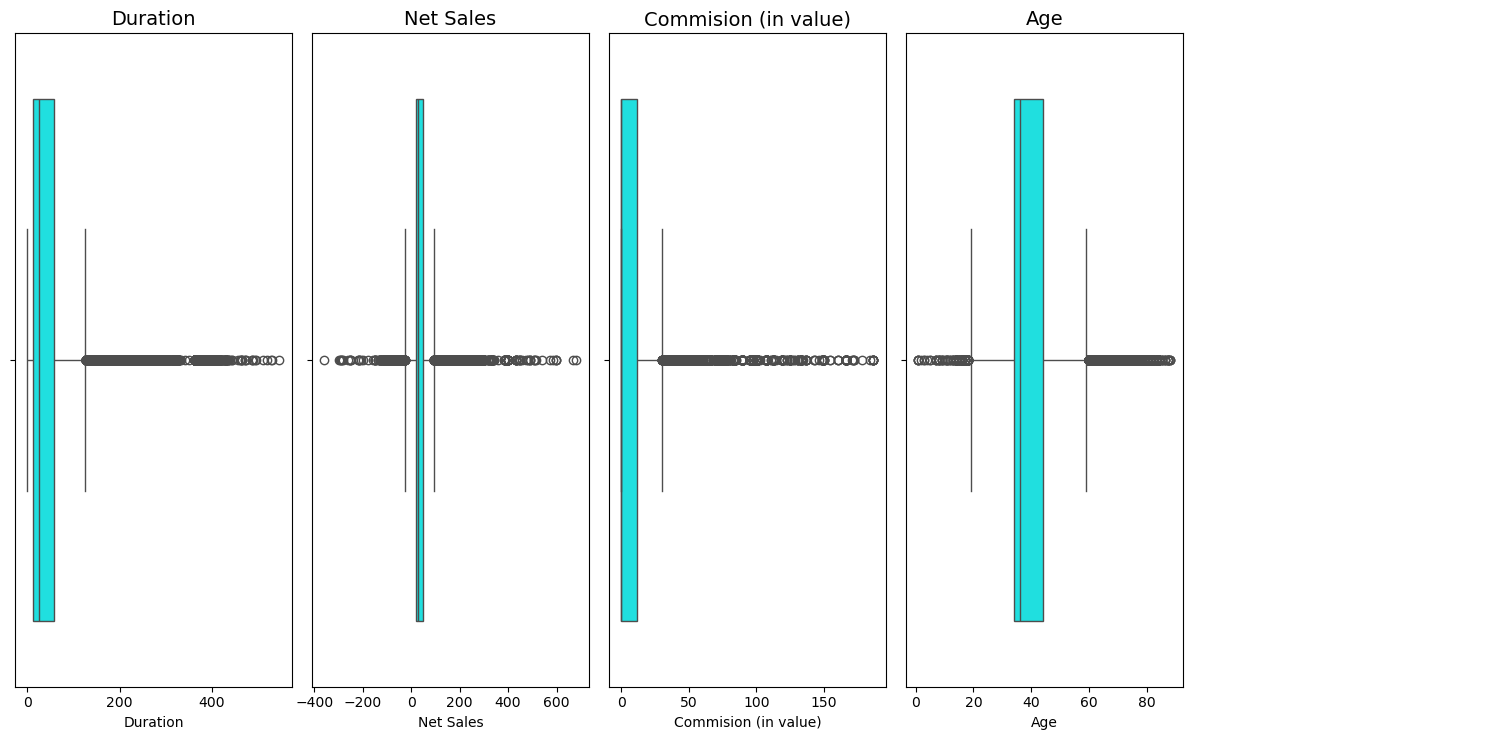

In [21]:
numerical_cols = df.select_dtypes(include=['number']).columns
num_cols = 5
num_rows = int(np.ceil(len(numerical_cols) / num_cols))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 7.5))


axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x=col, ax=axes[i], color='cyan')
    axes[i].set_title(col, fontsize=14)

        
for ax in axes[len(numerical_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

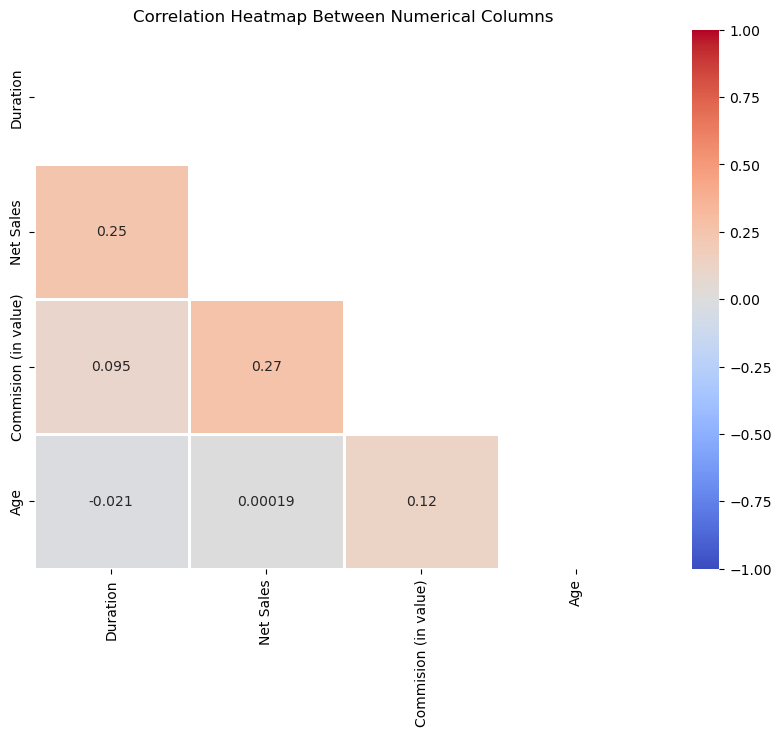

In [22]:
plt.figure(figsize=(10,7))
corr_df = df.corr(numeric_only=True, method='spearman') # Most numerical columns are not normally distributed (see prev. section)
mask_for_corr = np.ones_like(corr_df,dtype='bool')
mask_for_corr = np.triu(mask_for_corr) # Set elements of the upper triangle to zeroes (s.t. it's not displayed)

sns.heatmap(corr_df, vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask_for_corr, annot=True, linecolor='white', linewidth=1)
plt.xticks(rotation=90)
plt.title("Correlation Heatmap Between Numerical Columns")
plt.show()

In [23]:
categorical_cols = df.drop(columns=['Claim']).select_dtypes(include=['object']).columns
df[categorical_cols].describe()

,Agency,Agency Type,Distribution Channel,Product Name,Destination
count,38848,38848,38848,38848,38848
unique,15,2,2,26,136
top,EPX,Travel Agency,Online,Cancellation Plan,SINGAPORE
freq,20961,28007,38195,11007,8084


In [24]:
for col in categorical_cols:
    display(df[col].value_counts())

Agency
EPX    20961
CWT     5725
C2B     5333
JZI     4185
SSI      691
RAB      440
LWC      415
TST      327
KML      229
ART      192
CCR       95
CSR       68
CBH       67
TTW       66
ADM       54
Name: count, dtype: int64

Agency Type
Travel Agency    28007
Airlines         10841
Name: count, dtype: int64

Distribution Channel
Online     38195
Offline      653
Name: count, dtype: int64

Product Name
Cancellation Plan                       11007
2 way Comprehensive Plan                 8109
Rental Vehicle Excess Insurance          5725
Basic Plan                               3599
Bronze Plan                              2634
1 way Comprehensive Plan                 1845
Silver Plan                              1480
Value Plan                               1223
Annual Silver Plan                        848
Ticket Protector                          691
Travel Cruise Protect                     326
Gold Plan                                 235
Comprehensive Plan                        221
24 Protect                                170
Annual Gold Plan                          136
Single Trip Travel Protect Gold           134
Premier Plan                              117
Single Trip Travel Protect Silver         116
Annual Travel Protect Silver               59
Annual Travel Protect Gold                 57
Single Trip Travel Protect Platinum        47
Individual Comprehens

Destination
SINGAPORE           8084
THAILAND            3634
MALAYSIA            3155
CHINA               2916
AUSTRALIA           2452
                    ... 
LATVIA                 1
JAMAICA                1
FRENCH POLYNESIA       1
URUGUAY                1
REUNION                1
Name: count, Length: 136, dtype: int64

In [25]:
(pd.crosstab(index=df['Agency Type'], columns=df['Claim'],normalize=0) * 100).round(2)
## Ordinal: Airlines: 2, Travel Agency: 1

Claim,No,Yes
Agency Type,,
Airlines,96.02,3.98
Travel Agency,99.17,0.83


In [26]:
(pd.crosstab(index=df['Distribution Channel'], columns=df['Claim'],normalize=0) * 100).round(2)

Claim,No,Yes
Distribution Channel,,
Offline,98.77,1.23
Online,98.29,1.71


In [27]:
product_name_claim_count = (pd.crosstab(index=df['Product Name'], columns=df['Claim'],normalize=0) * 100).round(2).sort_values('Yes',ascending=False)
product_name_claim_count
# Ordinal relationship present

Claim,No,Yes
Product Name,,
Annual Silver Plan,87.38,12.62
Annual Gold Plan,88.24,11.76
Single Trip Travel Protect Platinum,89.36,10.64
Annual Travel Protect Gold,89.47,10.53
Spouse or Parents Comprehensive Plan,92.31,7.69
Silver Plan,92.70,7.30
Annual Travel Protect Silver,93.22,6.78
Bronze Plan,93.93,6.07
Single Trip Travel Protect Gold,94.78,5.22


In [28]:
df['Claim'] = np.where(df['Claim'] == 'Yes', 1, 0)
df['Claim']

0        0
1        0
2        0
3        0
4        0
        ..
44323    1
44324    0
44325    0
44326    0
44327    0
Name: Claim, Length: 38848, dtype: int64

## **X-Y split**

In [29]:
X, y = df.drop(columns=['Claim']), df['Claim']
display(X)
display(y)

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,57
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.00,33
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.00,59
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28
...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,30.0,0.00,36
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,47
44325,TST,Travel Agency,Offline,Travel Cruise Protect,64,THAILAND,30.0,10.50,50
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,CHINA,36.0,0.00,36


0        0
1        0
2        0
3        0
4        0
        ..
44323    1
44324    0
44325    0
44326    0
44327    0
Name: Claim, Length: 38848, dtype: int64

## **Train-Test Split**

In [30]:
(y.value_counts(normalize=True) * 100).round(2)

Claim
0    98.29
1     1.71
Name: proportion, dtype: float64

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=y)

In [32]:
(y_test.value_counts(normalize=True) * 100).round(2)

Claim
0    98.29
1     1.71
Name: proportion, dtype: float64

In [33]:
(y_train.value_counts(normalize=True) * 100).round(2)

Claim
0    98.29
1     1.71
Name: proportion, dtype: float64

## **Preprocessing**

In [34]:
product_name_claim_count

Claim,No,Yes
Product Name,,
Annual Silver Plan,87.38,12.62
Annual Gold Plan,88.24,11.76
Single Trip Travel Protect Platinum,89.36,10.64
Annual Travel Protect Gold,89.47,10.53
Spouse or Parents Comprehensive Plan,92.31,7.69
Silver Plan,92.70,7.30
Annual Travel Protect Silver,93.22,6.78
Bronze Plan,93.93,6.07
Single Trip Travel Protect Gold,94.78,5.22


In [35]:
product_name_mapping = dict()
for product_name in product_name_claim_count.index:
    if product_name in product_name_claim_count.query('Yes > 10').index:
        product_name_mapping[product_name] = 2
    elif product_name in product_name_claim_count.query('Yes <= 10 and Yes >=1').index:
        product_name_mapping[product_name] = 1
    else:
        product_name_mapping[product_name] = 0
product_name_mapping

{'Annual Silver Plan': 2,
 'Annual Gold Plan': 2,
 'Single Trip Travel Protect Platinum': 2,
 'Annual Travel Protect Gold': 2,
 'Spouse or Parents Comprehensive Plan': 1,
 'Silver Plan': 1,
 'Annual Travel Protect Silver': 1,
 'Bronze Plan': 1,
 'Single Trip Travel Protect Gold': 1,
 'Gold Plan': 1,
 'Single Trip Travel Protect Silver': 1,
 'Premier Plan': 1,
 'Comprehensive Plan': 1,
 '2 way Comprehensive Plan': 1,
 'Rental Vehicle Excess Insurance': 1,
 'Value Plan': 0,
 'Ticket Protector': 0,
 'Travel Cruise Protect': 0,
 'Basic Plan': 0,
 '1 way Comprehensive Plan': 0,
 'Cancellation Plan': 0,
 'Individual Comprehensive Plan': 0,
 'Child Comprehensive Plan': 0,
 'Annual Travel Protect Platinum': 0,
 '24 Protect': 0,
 'Travel Cruise Protect Family': 0}

In [36]:
ordinal_encoding_maps = [
    {
    'col': 'Agency Type',
    'mapping': {
        'Airlines': 2,
        'Travel Agency':1
        }
},
{
    'col': 'Product Name',
    'mapping': product_name_mapping
}]

ordinal_encoding_maps

[{'col': 'Agency Type', 'mapping': {'Airlines': 2, 'Travel Agency': 1}},
 {'col': 'Product Name',
  'mapping': {'Annual Silver Plan': 2,
   'Annual Gold Plan': 2,
   'Single Trip Travel Protect Platinum': 2,
   'Annual Travel Protect Gold': 2,
   'Spouse or Parents Comprehensive Plan': 1,
   'Silver Plan': 1,
   'Annual Travel Protect Silver': 1,
   'Bronze Plan': 1,
   'Single Trip Travel Protect Gold': 1,
   'Gold Plan': 1,
   'Single Trip Travel Protect Silver': 1,
   'Premier Plan': 1,
   'Comprehensive Plan': 1,
   '2 way Comprehensive Plan': 1,
   'Rental Vehicle Excess Insurance': 1,
   'Value Plan': 0,
   'Ticket Protector': 0,
   'Travel Cruise Protect': 0,
   'Basic Plan': 0,
   '1 way Comprehensive Plan': 0,
   'Cancellation Plan': 0,
   'Individual Comprehensive Plan': 0,
   'Child Comprehensive Plan': 0,
   'Annual Travel Protect Platinum': 0,
   '24 Protect': 0,
   'Travel Cruise Protect Family': 0}}]

In [37]:
transformer = ColumnTransformer([
    ('ordinal', OrdinalEncoder(cols=['Agency Type', 'Product Name'], mapping=ordinal_encoding_maps), ['Agency Type', 'Product Name']),
    ('binary', BinaryEncoder(), ['Agency', 'Distribution Channel', 'Destination']),
    ('robust', RobustScaler(), ['Duration', 'Net Sales', 'Commision (in value)', 'Age'])
], remainder='passthrough')
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinal',
                                 OrdinalEncoder(cols=['Agency Type',
                                                      'Product Name'],
                                                mapping=[{'col': 'Agency Type',
                                                          'data_type': dtype('O'),
                                                          'mapping': Airlines         2
Travel Agency    1
dtype: int64},
                                                         {'col': 'Product Name',
                                                          'data_type': dtype('O'),
                                                          'mapping': Annual Silver Plan                      2
Annual Gold Plan                        2
Single Trip Travel Protect Platinum     2
Annual Travel Protect...
1 way Comprehensive Plan                0
Cancellation Plan                       0
Individual Comprehensive Plan           0
Child Comprehensive Plan                0
Annual Travel Protect Platinum          0
24 Protect                              0
Travel Cruise Protect Family            0
dtype: int64}]),
                                 ['Agency Type', 'Product Name']),
                                ('binary', BinaryEncoder(),
                                 ['Agency', 'Distribution Channel',
                                  'Destination']),
                                ('robust', RobustScaler(),
                                 ['Duration', 'Net Sales',
                                  'Commision (in value)', 'Age'])])

## **Benchmark Model**

In [38]:
df

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,57,0
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.00,33,0
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.00,59,0
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28,0
...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,30.0,0.00,36,1
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,47,0
44325,TST,Travel Agency,Offline,Travel Cruise Protect,64,THAILAND,30.0,10.50,50,0
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,CHINA,36.0,0.00,36,0


In [39]:
(y_train.value_counts(normalize=True) * 100).round(2)

Claim
0    98.29
1     1.71
Name: proportion, dtype: float64

In [40]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinal',
                                 OrdinalEncoder(cols=['Agency Type',
                                                      'Product Name'],
                                                mapping=[{'col': 'Agency Type',
                                                          'data_type': dtype('O'),
                                                          'mapping': Airlines         2
Travel Agency    1
dtype: int64},
                                                         {'col': 'Product Name',
                                                          'data_type': dtype('O'),
                                                          'mapping': Annual Silver Plan                      2
Annual Gold Plan                        2
Single Trip Travel Protect Platinum     2
Annual Travel Protect...
1 way Comprehensive Plan                0
Cancellation Plan                       0
Individual Comprehensive Plan           0
Child Comprehensive Plan                0
Annual Travel Protect Platinum          0
24 Protect                              0
Travel Cruise Protect Family            0
dtype: int64}]),
                                 ['Agency Type', 'Product Name']),
                                ('binary', BinaryEncoder(),
                                 ['Agency', 'Distribution Channel',
                                  'Destination']),
                                ('robust', RobustScaler(),
                                 ['Duration', 'Net Sales',
                                  'Commision (in value)', 'Age'])])

In [41]:
pos_class_weight = (y_train==0).sum() / (y_train==1).sum() # Initial guess
pos_class_weight

57.637735849056604

In [42]:
pipe_base = Pipeline([
    ('preprocessing', transformer),
    ('model', XGBClassifier(random_state=0, scale_pos_weight=pos_class_weight, max_delta_step=1))
])

pipe_base

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(cols=['Agency '
                                                                       'Type',
                                                                       'Product '
                                                                       'Name'],
                                                                 mapping=[{'col': 'Agency '
                                                                                  'Type',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': Airlines         2
Travel Agency    1
dtype: int64},
                                                                          {'col': 'Product '
                                                                                  'Name',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': Annual Silver Plan                      2
Annual Gold Plan                        2
Single Trip...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=1,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=0, ...))])

CV Recall: [0.4528 0.3962 0.4151 0.434  0.3774 0.3774 0.5283 0.4717 0.3019 0.4151]
CV Recall Mean: 0.417
CV Recall Std: 0.0581
Train Recall: 0.9962
Test Recall: 0.4135


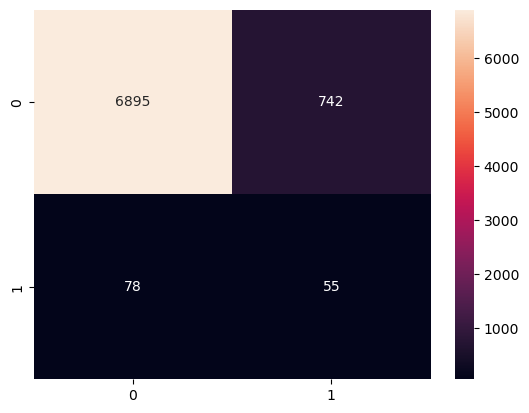

In [43]:
skfold = StratifiedKFold(n_splits = 10, shuffle=True,random_state=0)
cv_score = cross_val_score(
        pipe_base, 
        X_train, 
        y_train, 
        cv = skfold, 
        scoring = 'recall',
        )

pipe_base.fit(X_train, y_train)
y_pred_base = pipe_base.predict(X_test)
recall_train = recall_score(y_train, pipe_base.predict(X_train))
recall_test = recall_score(y_test, y_pred_base)

print(f"CV Recall: {np.round(cv_score,4)}")
print("CV Recall Mean:", np.mean(cv_score).round(4))
print("CV Recall Std:", np.std(cv_score).round(4))
print("Train Recall:", recall_train.round(4))
print("Test Recall:", recall_test.round(4))

sns.heatmap(confusion_matrix(y_test, y_pred_base), annot=True, fmt='g');

## **Tuning**

In [44]:
df

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,57,0
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.00,33,0
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.00,59,0
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28,0
...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,30.0,0.00,36,1
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,47,0
44325,TST,Travel Agency,Offline,Travel Cruise Protect,64,THAILAND,30.0,10.50,50,0
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,CHINA,36.0,0.00,36,0


In [45]:
(y_train.value_counts(normalize=True) * 100).round(2)

Claim
0    98.29
1     1.71
Name: proportion, dtype: float64

XGB CLASSIFIER PIPELINE BEFORE TUNING
CV Recall: [0.4528 0.3962 0.4151 0.434  0.3774 0.3774 0.5283 0.4717 0.3019 0.4151]
CV Recall Mean: 0.417
CV Recall Std: 0.0581
Train Recall: 0.9962
Test Recall: 0.4135


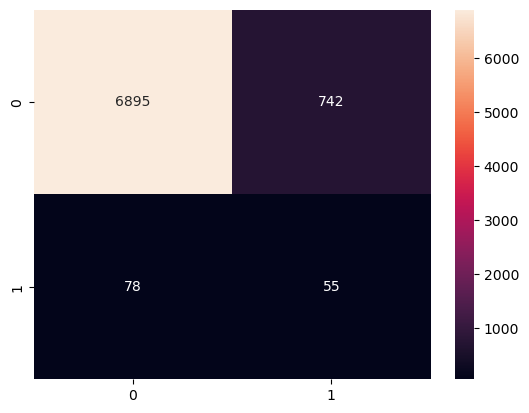

In [46]:
skfold = StratifiedKFold(n_splits = 10, shuffle=True,random_state=0)
cv_score = cross_val_score(
        pipe_base, 
        X_train, 
        y_train, 
        cv = skfold, 
        scoring = 'recall',
        )

pipe_base.fit(X_train, y_train)
y_pred_base = pipe_base.predict(X_test)
recall_train = recall_score(y_train, pipe_base.predict(X_train))
recall_test = recall_score(y_test, y_pred_base)

print("XGB CLASSIFIER PIPELINE BEFORE TUNING")
print(f"CV Recall: {np.round(cv_score,4)}")
print("CV Recall Mean:", np.mean(cv_score).round(4))
print("CV Recall Std:", np.std(cv_score).round(4))
print("Train Recall:", recall_train.round(4))
print("Test Recall:", recall_test.round(4))

sns.heatmap(confusion_matrix(y_test, y_pred_base), annot=True, fmt='g');

In [47]:
from hyperopt import hp, tpe, Trials, STATUS_OK, space_eval, fmin
from hyperopt.pyll import scope

In [48]:
params_space = {
        'max_depth' : hp.choice('max_depth',range(3, 12, 1)), # low values to reduce overfitting
        'n_estimators' : scope.int(hp.quniform("n_estimators", 50, 100,5)), # low values to reduce overfitting
        'learning_rate' : hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)), # low values to reduce overfitting
        'min_child_weight': scope.int(hp.quniform("min_child_weight", 10, 40, 1)), # high values to reduce overfitting
        'scale_pos_weight': hp.uniform("scale_pos_weight", 40, 80), # high values because data is highly imbalanced
        'max_delta_step': hp.choice("max_delta_step", [1,3,5]), # low values to reduce overfitting
        'subsample': hp.choice("subsample", [0.5,0.6, 0.7, 0.8, 0.9, 1.0]), # values between 0.5-1.0 to reduce overfitting
        'colsample_bytree': hp.choice("colsample_bytree", [0.5, 0.6, 0.7, 0.8, 0.9, 1.0])  # values between 0.5-1.0 to reduce overfitting
    }

In [49]:
def objective(args):
    
    model_pipe = Pipeline([
        ('preprocessing', transformer),
        ('model', XGBClassifier(random_state=0, **args))])
    
    skfold = StratifiedKFold(n_splits = 5, shuffle=True,random_state=0)
    model_cv = cross_val_score(
        model_pipe, 
        X_train, 
        y_train, 
        cv = skfold, 
        scoring = 'recall',
        )
    
    loss_score = 1 - model_cv.mean()

    return {'loss': loss_score, 'status': STATUS_OK}


In [50]:
# Initiate a Trial object 
trials = Trials()

tuning_result = fmin(fn=objective, 
                     space=params_space, 
                     algo=tpe.suggest,
                     max_evals=50, 
                     trials=trials, 
                     rstate=np.random.default_rng(0))

# Best_params from trials
best_params = space_eval(params_space, tuning_result)

100%|██████████| 50/50 [01:05<00:00,  1.32s/trial, best loss: 0.20377358490566022]


In [51]:
best_params

{'colsample_bytree': 0.6,
 'learning_rate': 0.015807867546248376,
 'max_delta_step': 3,
 'max_depth': 5,
 'min_child_weight': 37,
 'n_estimators': 55,
 'scale_pos_weight': 79.98123451682935,
 'subsample': 0.8}

In [52]:
pipe_tune = Pipeline([
    ('preprocessing', transformer),
    ('model', XGBClassifier(random_state=0, **best_params))
])

In [53]:
pipe_tune.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(cols=['Agency '
                                                                       'Type',
                                                                       'Product '
                                                                       'Name'],
                                                                 mapping=[{'col': 'Agency '
                                                                                  'Type',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': Airlines         2
Travel Agency    1
dtype: int64},
                                                                          {'col': 'Product '
                                                                                  'Name',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': Annual Silver Plan                      2
Annual Gold Plan                        2
Single Trip...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.015807867546248376, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=3, max_depth=5, max_leaves=None,
                               min_child_weight=37, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=55, n_jobs=None,
                               num_parallel_tree=None, random_state=0, ...))])

XGB CLASSIFIER PIPELINE AFTER TUNING
CV Recall: [0.8302 0.7358 0.7547 0.8491 0.717  0.7358 0.8868 0.8679 0.8113 0.8302]
CV Recall Mean: 0.8019
CV Recall Std: 0.058
Train Recall: 0.8925
Test Recall: 0.8195


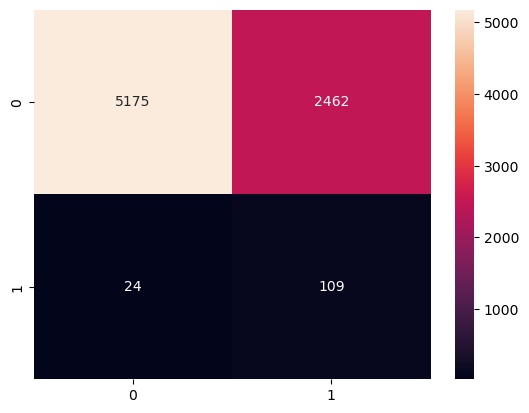

In [54]:
skfold = StratifiedKFold(n_splits = 10, shuffle=True,random_state=0)

cv_score = cross_val_score(
        pipe_tune, 
        X_train, 
        y_train, 
        cv = skfold, 
        scoring = 'recall',
        )

pipe_tune.fit(X_train, y_train)
y_pred_tune = pipe_tune.predict(X_test)
recall_train = recall_score(y_train, pipe_tune.predict(X_train))
recall_test = recall_score(y_test, y_pred_tune)

print("XGB CLASSIFIER PIPELINE AFTER TUNING")
print(f"CV Recall: {np.round(cv_score,4)}")

print("CV Recall Mean:", np.mean(cv_score).round(4))
print("CV Recall Std:", np.std(cv_score).round(4))
print("Train Recall:", recall_train.round(4))
print("Test Recall:", recall_test.round(4))

sns.heatmap(confusion_matrix(y_test, y_pred_tune), annot=True, fmt='g');

In [55]:
accuracy_score(y_train, pipe_tune.predict(X_train))

0.6942853465473968

In [56]:
accuracy_score(y_test, y_pred_tune)

0.6800514800514801